In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import pydotmap as DotMap

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02, exp01
import aeon.schema.foraging
from aeon.analysis.utils import visits, distancetravelled

import sys

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

# Data

In [5]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Declare some set-up variables to help with analysis

# Specify which animals in which room
in_b2_210 = ("48", "49", "50")
in_465 = ("45", "47")

# Columns to add to table
new_cols = (
    "post_thresh_dur", 
    "post_thresh_both_p_sampled_dur",
    "pre_sampling_both_p_dur", 
    "easy_patch", 
    "hard_patch", 
    "post_easy_rate", 
    "post_hard_rate", 
    "pre_easy_n_pel", 
    "pre_hard_n_pel", 
    "post_easy_n_pel", 
    "post_hard_n_pel", 
    "pre_easy_wheel_dist", 
    "pre_hard_wheel_dist",
    "post_easy_wheel_dist", 
    "post_hard_wheel_dist", 
    "pre_easy_pref", 
    "post_easy_pref",
    "pre_hard_pref", 
    "post_hard_pref", 
    "post_pre_easy_pref", 
    "post_easy_pel_thresh", 
    "post_easy_pel_thresh_idx", 
    "post_hard_pel_thresh", 
    "post_hard_pel_thresh_idx", 
    "init_pref_by_pel_ct", 
    "epoch_thresh_change_idx", 
    "easy_pref_epoch_cum", 
    "easy_pref_epoch",
    "cont_patch_pref"
)
for col in new_cols: sessions[col] = np.nan

sessions["post_easy_pel_thresh"] = sessions["post_easy_pel_thresh"].astype(object)
sessions["post_hard_pel_thresh"] = sessions["post_hard_pel_thresh"].astype(object)
sessions["post_easy_pel_thresh_idx"] = sessions["post_easy_pel_thresh_idx"].astype(object)
sessions["post_hard_pel_thresh_idx"] = sessions["post_hard_pel_thresh_idx"].astype(object)
sessions["init_pref_by_pel_ct"] = sessions["init_pref_by_pel_ct"].astype(object)
sessions["easy_pref_epoch_cum"] = sessions["easy_pref_epoch_cum"].astype(object)
sessions["easy_pref_epoch"] = sessions["easy_pref_epoch"].astype(object)
sessions["cont_patch_pref"] = sessions["cont_patch_pref"].astype(object)

display(sessions)

,id,weight_enter,weight_exit,enter,exit,duration,post_thresh_dur,post_thresh_both_p_sampled_dur,pre_sampling_both_p_dur,easy_patch,...,post_pre_easy_pref,post_easy_pel_thresh,post_easy_pel_thresh_idx,post_hard_pel_thresh,post_hard_pel_thresh_idx,init_pref_by_pel_ct,epoch_thresh_change_idx,easy_pref_epoch_cum,easy_pref_epoch,cont_patch_pref
0,BAA-1100700,26.40,28.10,2022-02-23 14:21:25.550300121,2022-02-25 16:00:50.076419830,2 days 01:39:24.526119709,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAA-1100700,25.50,28.45,2022-03-02 13:47:43.875840187,2022-03-02 18:14:47.459969997,0 days 04:27:03.584129810,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAA-1100700,24.55,24.55,2022-03-04 14:00:01.818980217,2022-03-04 14:00:49.259260178,0 days 00:00:47.440279961,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAA-1100700,24.55,28.27,2022-03-04 14:04:16.610499859,2022-03-04 19:24:41.778140068,0 days 05:20:25.167640209,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAA-1100700,26.30,26.30,2022-03-15 12:40:36.282139778,2022-03-15 15:56:55.801119804,0 days 03:16:19.518980026,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,BAA-1100700,27.60,28.80,2022-03-16 15:06:37.790820122,2022-03-16 16:44:50.910079956,0 days 01:38:13.119259834,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BAA-1100700,25.50,28.50,2022-03-17 15:56:35.478690147,2022-03-17 17:41:48.763070107,0 days 01:45:13.284379960,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BAA-1100700,24.30,26.80,2022-03-23 14:47:58.253819942,2022-03-24 14:08:54.449150085,0 days 23:20:56.195330143,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,BAA-1100699,26.75,29.00,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BAA-1100701,27.00,26.70,2022-04-04 13:59:13.352029800,2022-04-04 15:19:41.652349949,0 days 01:20:28.300320149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
w_chunk_t = 500         # time chunks in samples (1 sample = 2 ms)
w_chunk_dist = 500      # distance chunks in cm
pref_window = 3000      # distance in cm
pref_thresh = 0.80      # preference threshold to check over `pref_window`
n_distris = 100         # number of diff distributions to generate

# Pick an Example Session

In [7]:
# BAA-1100701
session = list(sessions.itertuples())[10]

# Patch Delivery

In [8]:
harp_reader = reader.Harp(pattern="Patch1_35*", columns=["TriggerPellet"])
    
new_pellet_trig_bitmask = api.load(root, harp_reader, start=session.enter, end=session.exit).iloc[0, 0]
new_pellet_trig_reader_p1 = reader.BitmaskEvent("Patch1_35*", new_pellet_trig_bitmask, "TriggerPellet")
new_pellet_trig_reader_p2 = reader.BitmaskEvent("Patch2_35*", new_pellet_trig_bitmask, "TriggerPellet")
    

p1 = api.load(root, new_pellet_trig_reader_p1, start=session.enter, end=session.exit)
p2 = api.load(root, new_pellet_trig_reader_p2, start=session.enter, end=session.exit)

# PelletTrig cleaning: remove repeated deliveries (events <1.5 s apart) and manual deliveries (201)
p1 = p1.drop(p1.index[np.where(np.diff(p1.index).astype("float64") < 1.5e9)[0]])
p2 = p2.drop(p2.index[np.where(np.diff(p2.index).astype("float64") < 1.5e9)[0]])

harp_reader = reader.Harp(pattern="Patch1_201", columns=["ExperimenterDeliveries"])
user_p1 = api.load(root, harp_reader, start=session.enter, end=session.exit)

harp_reader = reader.Harp(pattern="Patch2_201", columns=["ExperimenterDeliveries"])
user_p2 = api.load(root, harp_reader, start=session.enter, end=session.exit)

if not user_p1.empty:
    user_p1_idxs = np.abs(np.subtract.outer(user_p1.index, p1.index)).argmin(axis=1)
    p1.drop(p1.index[user_p1_idxs])
if not user_p2.empty:
    user_p2_idxs = np.abs(np.subtract.outer(user_p2.index, p2.index)).argmin(axis=1)
    p2.drop(p2.index[user_p2_idxs])
    
both_pellet_data = pd.concat([p1, p2]).sort_index()

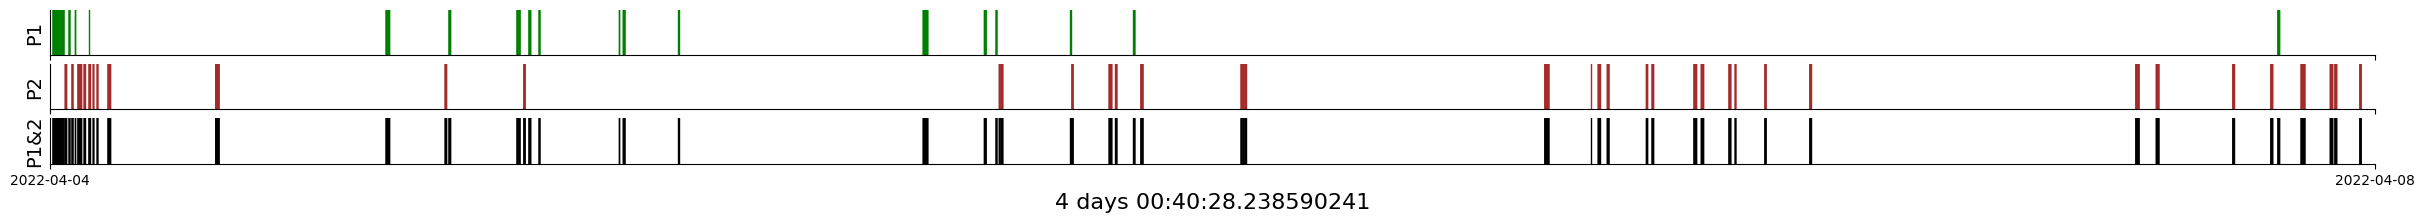

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(30, 2), sharex=True)

for pellet in p1.itertuples(): axs[0].axvline(pd.Timestamp(pellet.Index), color='green', linewidth=1)
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('P1', fontsize = 14)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlim(session.enter, session.exit)

for pellet in p2.itertuples(): axs[1].axvline(pd.Timestamp(pellet.Index), color='brown', linewidth=1)
axs[1].set_yticks([])  
axs[1].set_facecolor('white')  
axs[1].set_ylabel('P2', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlim(session.enter, session.exit)

for pellet in both_pellet_data.itertuples(): axs[2].axvline(pd.Timestamp(pellet.Index), color='black', linewidth=1)
axs[2].set_yticks([])  
axs[2].set_facecolor('white')  
axs[2].set_ylabel('P1&2', fontsize = 14)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_xlim(session.enter, session.exit)
    
axs[2].set_xticks([pd.Timestamp(session.enter), pd.Timestamp(session.exit)])
axs[2].set_xlabel(str(session.duration), fontsize = 16)
plt.show()

# Patch Depletion State

In [10]:
pstate1 = api.load(root, exp02.Patch1.DepletionState, start=session.enter, end=session.exit)
pstate2 = api.load(root, exp02.Patch2.DepletionState, start=session.enter, end=session.exit)

# PatchState cleaning: remove NaNs; remove updates <1.5s apart (bug updates)
pstate1.dropna(inplace=True)
good_indxs = np.concatenate((np.diff(pstate1.index).astype("float64") > 1.5e9, [True]))
pstate1 = pstate1[good_indxs]
pstate2.dropna(inplace=True)
good_indxs = np.concatenate((np.diff(pstate2.index).astype("float64") > 1.5e9, [True]))
pstate2 = pstate2[good_indxs]

# Clean known issues in particular sessions
if session.enter == pd.Timestamp("2023-03-24 14:22:48"):  # last threshold update of 75 for some reason
    pstate1 = pstate1.drop(pstate1.index[-1])
    pstate2 = pstate2.drop(pstate2.index[-1])
if session.enter == pd.Timestamp("2023-03-10 13:08:24"):  # TriggerPellet at very end of session for some reason
    p2 = p2.drop(p2.index[-1])
if session.enter == pd.Timestamp("2023-06-15 13:33:30"):  # @todo check this
    p2 = p2.drop(p2.index[-4:])
if session.enter == pd.Timestamp("2023-06-21 09:49:02"):  # @todo check this
    pstate1 = pstate1.drop(pstate1.index[-2:])
        
    # Check lengths of PelletTrigger and PatchState events
if ((len(pstate1) - len(p1)) not in (0, 1, 2)) or ((len(pstate2) - len(p2)) not in (0, 1, 2)):
    raise Exception(
            f"PelletTrigger-PatchState mismatch: \n"
            f"len(p1) = {len(p1)} \n"
            f"len(p2) = {len(p2)} \n"
            f"len(pstate1) = {len(pstate1)} \n"
            f"len(pstate2) = {len(pstate2)} \n"
        )
both_state_data = pd.concat([pstate1, pstate2]).sort_index()

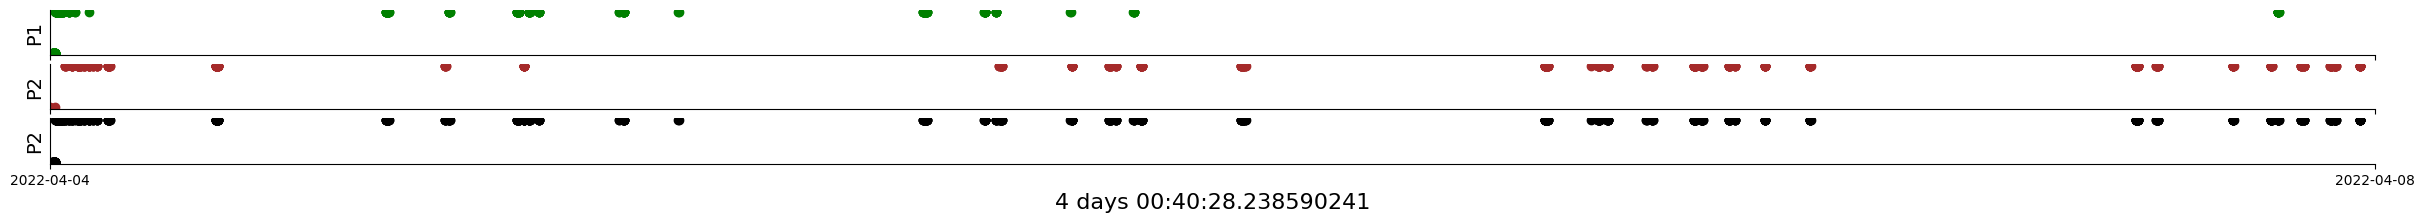

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(30, 2), sharex=True)

for pellet in pstate1.itertuples(): axs[0].scatter(pd.Timestamp(pellet.Index), pellet.threshold, color='green')
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('P1', fontsize = 14)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlim(session.enter, session.exit)

for pellet in pstate2.itertuples(): axs[1].scatter(pd.Timestamp(pellet.Index), pellet.threshold, color='brown')
axs[1].set_yticks([])  
axs[1].set_facecolor('white')  
axs[1].set_ylabel('P2', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlim(session.enter, session.exit)

for pellet in both_state_data.itertuples(): axs[2].scatter(pd.Timestamp(pellet.Index), pellet.threshold, color='black')
axs[2].set_yticks([])  
axs[2].set_facecolor('white')  
axs[2].set_ylabel('P2', fontsize = 14)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_xlim(session.enter, session.exit)
    
axs[2].set_xticks([pd.Timestamp(session.enter), pd.Timestamp(session.exit)])
axs[2].set_xlabel(str(session.duration), fontsize = 16)
plt.show()

# Distance Travelled on Patch

In [12]:
encoder1 = api.load(root, exp02.Patch1.Encoder, start=session.enter, end=session.exit)
w1 = -distancetravelled(encoder1.angle)
w1_with_time = pd.DataFrame(w1.reset_index())
    
encoder2 = api.load(root, exp02.Patch2.Encoder, start=session.enter, end=session.exit)
w2 = -distancetravelled(encoder2.angle)
w2_with_time = pd.DataFrame(w2.reset_index())

wboth = w1 + w2

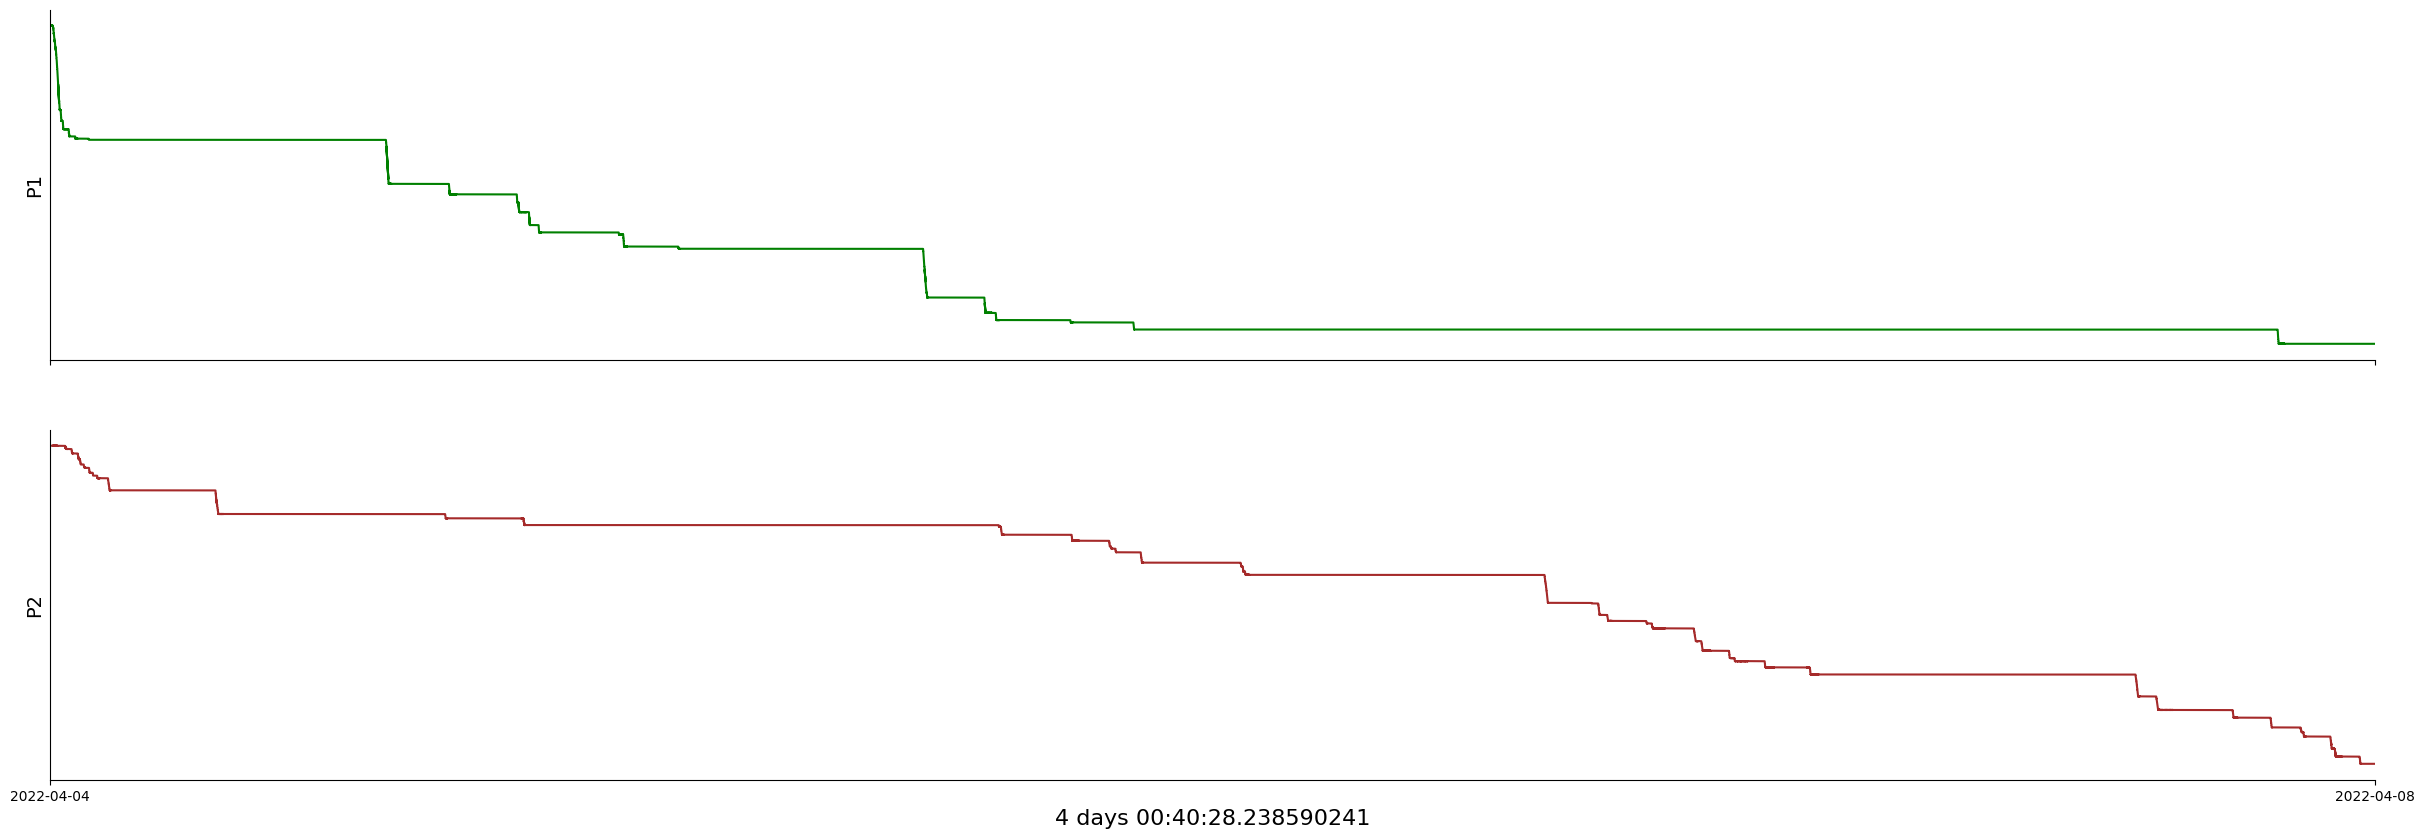

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

axs[0].plot(w1_with_time['time'].to_numpy(), w1_with_time['angle'].to_numpy(), color='green')
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('P1', fontsize = 14)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlim(session.enter, session.exit)

axs[1].plot(w2_with_time['time'].to_numpy(), w2_with_time['angle'].to_numpy(), color='brown')
axs[1].set_yticks([])  
axs[1].set_facecolor('white')  
axs[1].set_ylabel('P2', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlim(session.enter, session.exit)
    
axs[1].set_xticks([pd.Timestamp(session.enter), pd.Timestamp(session.exit)])
axs[1].set_xlabel(str(session.duration), fontsize = 16)
plt.show()

# Other Overall Analysis

## Post-threhold Duration

In [14]:
thresh_change_idx = np.where(np.abs(np.diff(both_state_data.threshold)) > 1)[0][0] + 1                           
                # Index at which patch depletion state changes for the first time, dtype = int
                
safe_change_ts = change_ts = both_state_data.index[thresh_change_idx]                                            
                # Actual time of the index, dtype = pd.Timestamp
                
sessions.loc[session.Index, "post_thresh_dur"] = post_thresh_dur = (session.exit - change_ts).round("1s")

## Both-patches-sampled Time: Pre-threshold change

In [15]:
both_patches_sampled_ts = pd.Series((p1.index[0], p2.index[0])).max()                                          
                # Actual time at which both patches have been sampled for at least one time, dtype = pd.Timestamp
                
sessions.loc[session.Index, "pre_sampling_both_p_dur"] = pre_sampling_b_patches_dur = (both_patches_sampled_ts - session.enter).round("1s") 
                # Actual duration from session starting until which both patches have been sampled for at least one time, dtype = pd.Timedelta

## Both-patches-sampled Time: Post-threshold Change

In [16]:
if (np.any(p1.index > safe_change_ts) and np.any(p2.index > safe_change_ts)):
    both_patches_sampled_ts_post = (
            pd.Series((p1.index[p1.index > safe_change_ts][0], 
                        p2.index[p2.index > safe_change_ts][0])).max()
        )
    sessions.loc[session.Index, "post_thresh_both_p_sampled_dur"] = (
            (both_patches_sampled_ts_post - safe_change_ts).round("1s")
        )
                # Actual duration from first threshold change until which both patches have been sampled for at least one time, dtype = pd.Timedelta

## Patch Hard/Easy Determination

In [17]:
# Special session
if session.enter == pd.Timestamp("2023-06-05 14:30:00"):
    pstate1["delta"][-1] = 0.002
    pstate2["delta"][-1] = 0.0033
    
sessions.loc[session.Index, "hard_patch"] = hard_patch = 1 if (pstate1["delta"][-1] < pstate2["delta"][-1]) else 2
sessions.loc[session.Index, "easy_patch"] = easy_patch = 1 if (hard_patch == 2) else 2

sessions.loc[session.Index, "post_hard_rate"] = post_hard_rate = pstate1["delta"][-1] if (hard_patch == 1) else pstate2["delta"][-1]
sessions.loc[session.Index, "post_easy_rate"] = post_easy_rate = pstate1["delta"][-1] if (hard_patch == 2) else pstate2["delta"][-1]

## Number of Food Deliveries for Hard/Easy Patch

In [18]:
p1_pre_n_pel = len(p1[p1.index <= (safe_change_ts + pd.Timedelta("1s"))])  
                # Number of patch delivery before threshold change, dtype = int
                # ensure we don't count last pellet in pre as first pellet in post
p1_post_n_pel = len(p1[p1.index > (safe_change_ts + pd.Timedelta("1s"))])
                # Number of patch delivery after threshold change, dtype = int

p2_pre_n_pel = len(p2[p2.index <= (safe_change_ts + pd.Timedelta("1s"))])
p2_post_n_pel = len(p2[p2.index > (safe_change_ts + pd.Timedelta("1s"))])

sessions.loc[session.Index, "pre_easy_n_pel"] = pre_easy_n_pel = p1_pre_n_pel if (easy_patch == 1) else p2_pre_n_pel
sessions.loc[session.Index, "pre_hard_n_pel"] = pre_hard_n_pel = p1_pre_n_pel if (hard_patch == 1) else p2_pre_n_pel

sessions.loc[session.Index, "post_easy_n_pel"] = post_easy_n_pel = p1_post_n_pel if (easy_patch == 1) else p2_post_n_pel
sessions.loc[session.Index, "post_hard_n_pel"] = post_hard_n_pel = p1_post_n_pel if (hard_patch == 1) else p2_post_n_pel

## Distance Traveled in Hard/Easy Patch 

In [19]:
whard = w1 if (hard_patch == 1) else w2
weasy = w1 if (easy_patch == 1) else w2

p1_pre_wheel_dist = w1[w1.index > safe_change_ts][0] - w1[0]
                #Distance travelled on the wheel before threshold change, dtype = float
p1_post_wheel_dist = w1[-1] - p1_pre_wheel_dist
                #Distance travelled on the wheel after threshold change, dtype = float

p2_pre_wheel_dist = w2[w2.index > safe_change_ts][0] - w2[0]
p2_post_wheel_dist = w2[-1] - p2_pre_wheel_dist

sessions.loc[session.Index, "pre_easy_wheel_dist"] = pre_easy_wheel_dist = p1_pre_wheel_dist if (easy_patch == 1) else p2_pre_wheel_dist
sessions.loc[session.Index, "pre_hard_wheel_dist"] = pre_hard_wheel_dist = p1_pre_wheel_dist if (hard_patch == 1) else p2_pre_wheel_dist

sessions.loc[session.Index, "post_easy_wheel_dist"] = post_easy_wheel_dist = p1_post_wheel_dist if (easy_patch == 1) else p2_post_wheel_dist
sessions.loc[session.Index, "post_hard_wheel_dist"] = post_hard_wheel_dist = p1_post_wheel_dist if (hard_patch == 1) else p2_post_wheel_dist

## Percentage Distance Traveled in Hard/Easy Patch 

In [20]:
sessions.loc[session.Index, "pre_easy_pref"] = pre_easy_pref = pre_easy_wheel_dist / (pre_easy_wheel_dist + pre_hard_wheel_dist)
sessions.loc[session.Index, "post_easy_pref"] = post_easy_pref = post_easy_wheel_dist / (post_easy_wheel_dist + post_hard_wheel_dist)
sessions.loc[session.Index, "pre_hard_pref"] = post_hard_pref = 1 - pre_easy_pref
sessions.loc[session.Index, "post_hard_pref"] = post_hard_pref = 1 - post_easy_pref
sessions.loc[session.Index, "post_pre_easy_pref"] = post_pre_easy_pref = post_easy_pref / pre_easy_pref

## Patch State Prior to Each Threshold Crossing

In [21]:
p1_post_pel_thresh = pstate1[pstate1.index >= safe_change_ts].threshold[:-1]
                #p1_post_pel_thresh = np.nan if p1_post_pel_thresh.empty else p1_post_pel_thresh
p2_post_pel_thresh = pstate2[pstate2.index >= safe_change_ts].threshold[:-1]
                #p2_post_pel_thresh = np.nan if p2_post_pel_thresh.empty else p2_post_pel_thresh
post_easy_pel_thresh = p1_post_pel_thresh if (easy_patch == 1) else p2_post_pel_thresh
post_hard_pel_thresh = p1_post_pel_thresh if (hard_patch == 1) else p2_post_pel_thresh
    
sessions.at[session.Index, "post_easy_pel_thresh"] = post_easy_pel_thresh.values.round(3)
sessions.at[session.Index, "post_hard_pel_thresh"] = post_hard_pel_thresh.values.round(3)
sessions.at[session.Index, "post_easy_pel_thresh_idx"] = np.array(post_easy_pel_thresh.index.round("1s"))
sessions.at[session.Index, "post_hard_pel_thresh_idx"] = np.array(post_hard_pel_thresh.index.round("1s"))

## Distance traveled on the easy/hard wheel at the first timestamp after the current pellet delivery timestamp

In [22]:
init_pref_by_pel_ct = np.ones((10,)) * np.nan
for i, pel_ct in enumerate(range(8,18)): # Why i = 8 to 18 ?
    cur_pel_ct_ts = both_pellet_data.index[pel_ct]
                # Current pellet delivery timestamp
    if cur_pel_ct_ts > (safe_change_ts + pd.Timedelta("1s")):
        break
    cur_whard_dist = whard[whard.index > cur_pel_ct_ts][0] - whard[0]
                # Distance traveled on the hard wheel at the first timestamp after the current pellet delivery timestamp
    cur_weasy_dist = weasy[weasy.index > cur_pel_ct_ts][0] - weasy[0] 
    init_pref_by_pel_ct[i] = cur_whard_dist / (cur_whard_dist + cur_weasy_dist)
sessions.at[session.Index, "init_pref_by_pel_ct"] = init_pref_by_pel_ct

## Proportional distance traveled on the easy/hard wheel 

In [23]:
wboth_quantized = np.linspace(0, wboth[-1], 11)
                # Divide the total duration of foraging data into 10 intervals of equal distance traveled
easy_pref_epoch_cum = np.zeros((10,))
                # Arrays used to store cumulative epoch preferences for the easy patch
easy_pref_epoch = np.zeros((10,))
                # Arrays used to store individual epoch preferences for the easy patch
epoch_thresh_change_idx = 0
                # Index of the epoch during which the environment's depletion state changes
epoch_ts_pre = wboth.index[0]
                # Beginning of the epoch
for i in range(1, 10):
    epoch_ts_post = wboth[wboth > wboth_quantized[i]].index[0] - pd.Timedelta("1s")
                # End of the epoch
    if (epoch_ts_post > safe_change_ts) and not epoch_thresh_change_idx:
        epoch_thresh_change_idx = i
    weasy_pre = weasy[weasy.index > epoch_ts_pre][0]
                # Distance traveled on the easy patch after the previous epoch
    weasy_post = weasy[weasy.index > epoch_ts_post][0]
                # Distance traveled on the easy patch after the current epoch
    weasy_diff = weasy_post - weasy_pre
                # Distance traveled on the easy patch during the epoch        
                
    whard_post = whard[whard.index > epoch_ts_post][0]
    whard_pre = whard[whard.index > epoch_ts_pre][0]
    whard_diff = whard_post - whard_pre
                # Distance traveled on the hard patch during the epoch
                
    easy_pref_epoch_cum[i] = weasy_post / (weasy_post + whard_post)
    easy_pref_epoch[i] = weasy_diff / (weasy_diff + whard_diff)
    epoch_ts_pre = epoch_ts_post
    
sessions.at[session.Index, "easy_pref_epoch_cum"] = easy_pref_epoch_cum
sessions.at[session.Index, "easy_pref_epoch"] = easy_pref_epoch
sessions.loc[session.Index, "epoch_thresh_change_idx"] = epoch_thresh_change_idx

/tmp/ipykernel_727083/2830692319.py:28: RuntimeWarning: invalid value encountered in scalar divide
  easy_pref_epoch_cum[i] = weasy_post / (weasy_post + whard_post)
/tmp/ipykernel_727083/2830692319.py:29: RuntimeWarning: invalid value encountered in scalar divide
  easy_pref_epoch[i] = weasy_diff / (weasy_diff + whard_diff)
